In [1]:
#!python
import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
import time
import string
import sys
from types import MethodType

In [2]:
ALPHABET = np.array(list(string.ascii_letters))

def random_string(length):
    return "".join(np.random.choice(ALPHABET, size=length))

def create_dataset(rows=5, cols=[int, float, str, list], names=ALPHABET):
    rng = np.random.default_rng()

    data = {}
    for i in range(len(cols)):
        if cols[i] == int:
            data[names[i]] = rng.integers(0, 100, size=rows)
        elif cols[i] == float:
            data[names[i]] = rng.random(size=rows)
        elif cols[i] == str:
            vfunc = np.vectorize(random_string)
            rand_lengths = rng.integers(5, 25, size=rows)
            data[names[i]] = vfunc(rand_lengths)
        elif cols[i] == list:
            larr = []
            for j in range(rows):
                rand_length = rng.integers(5, 25, size=1)
                lst = rng.random(rand_length)
                larr.append(lst)
            data[names[i]] = larr
    return pa.table(data)

def table_to_struct(table):
    fields, arrs = [], []
    for column_index in range(table.num_columns):
        fields.append(table.field(column_index))
        arrs.append(table.column(column_index).flatten()[0].chunks[0])
    return pa.StructArray.from_arrays(arrs, fields=fields)


def struct_to_table(struct):
    fields, arrs = [], []
    for x in struct.slice(0, 1)[0].keys():
        fields.append(x)
        arrs.append(st.field(x))
    return pa.table(arrs, fields)

def struct_view(struct_name, parent):
    class struct_accessor:
        def __init__(self, name, parent):
            self.struct_name = name
            self.parent = parent

        def struct(self):
            return self.parent.table.column(self.struct_name).slice(self.parent.idx, 1)[0]
        
        def get(self, str):
            if hasattr(self, str):
                attr = getattr(self, str)
                if attr == MethodType:
                    return attr()
                return attr
            return None

    def add_accessor_fn(inst, name, type):
        fn_name = name

        def fn_list(self):
            return self.struct().get(name).values.to_numpy()

        def fn_scalar(self):
            return self.struct().get(name).as_py()

        if pa.types.is_list(type) or pa.types.is_large_list(type):
            setattr(inst, fn_name, MethodType(fn_list, inst))
        elif pa.types.is_struct(type):
            raise NotImplementedError
        else:
            setattr(inst, fn_name, MethodType(fn_scalar, inst))

    inst = struct_accessor(struct_name, parent)
    for name, val in inst.struct().items():
        add_accessor_fn(inst, name, val.type)

    return inst



def row_view(table, idx=0):
    class row_accessor:
        def __init__(self, table, idx):
            self.table = table
            self.idx = idx
        
        def get(self, str):
            if hasattr(self, str):
                attr = getattr(self, str)
                if attr == MethodType:
                    return attr()
                return attr
            return None

    def add_accessor_fn(inst, name, type):
        #fn_name = "get_" + name
        fn_name = name

        def fn_list(self):
            values = self.table.column(name).slice(self.idx, 1)[0].values
            if values:
                return values.to_numpy()
            return None

        def fn_scalar(self):
            return self.table.column(name).slice(self.idx, 1)[0].as_py()

        if pa.types.is_list(type) or pa.types.is_large_list(type):
            setattr(inst, fn_name, MethodType(fn_list, inst))
        elif pa.types.is_struct(type):
            sv = struct_view(name, inst)
            setattr(inst, fn_name, sv)
        else:
            setattr(inst, fn_name, MethodType(fn_scalar, inst))

    inst = row_accessor(table, idx)
    for col in table.column_names:
        add_accessor_fn(inst, col, table.column(col).type)

    return inst

def row_view_raw(table, idx=0):
    class row_accessor:
        def __init__(self, table, idx):
            self.table = table
            self.idx = idx

    def add_accessor_fn(inst, name, type):
        fn_name = "get_" + name
        def fn(self):
            return self.table.column(name).slice(self.idx, 1)[0]
        setattr(inst, fn_name, MethodType(fn, inst))

    inst = row_accessor(table, idx)
    for col in table.column_names:
        add_accessor_fn(inst, col, table.column(col).type)

    return inst

In [2]:
FILENAME = '/home/slottad/nist/gitlab/msdc_services/libraries/test.parquet'
table = pq.read_table(FILENAME)
table.to_pandas()

,id,charge,ev,instrument,instrument_type,ion_mode,ionization,name,scan,nce,...,precursor_intensity,precursor_massinfo,precursor_mz,spectrum_fp,spectrum_fp_count,spectrum_interval_fp,spectrum_interval_fp_count,peptide,mod_names,mod_positions
0,0,2,50.0,None,None,None,None,"AAAALGSHGSCSSEVEK/2_1(10,C,Carbamidomethyl)",None,34.0,...,NaN,"{'tolerance': 10.0, 'tolerance_type': 'ppm', '...",830.8834,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",67,None,NaN,AAAALGSHGSCSSEVEK,[Carbamidomethyl],[10]


In [49]:
table.column_names
table.column("annotations").type

LargeListType(large_list<item: struct<ion_type: dictionary<values=string, indices=int32, ordered=0>, product_charge: int8, isotope: uint8, neutral_loss: dictionary<values=string, indices=int32, ordered=0>, position: uint16, end_position: uint16, aa_before: dictionary<values=string, indices=int32, ordered=0>, aa_after: dictionary<values=string, indices=int32, ordered=0>, ptm_before: dictionary<values=string, indices=int32, ordered=0>, ptm_after: dictionary<values=string, indices=int32, ordered=0>>>)

In [51]:
FILENAME = '/home/slottad/nist/gitlab/msdc_services/libraries/test.parquet'
table = pq.read_table(FILENAME)
rv = row_view(table)
print(rv.get("junk"))

print(rv.get("annotations"))
print(rv.get("annotations")())
rv.spectrum_fp()

None
<bound method row_view.<locals>.add_accessor_fn.<locals>.fn_list of <__main__.row_view.<locals>.row_accessor object at 0x7fede011f280>>
None


array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [3]:
import massspec.utils.tables
row = massspec.utils.tables.row_view(table)
annotations = row.get("annotations")
annotations = None if annotations is None else annotations()
print(annotations)

None


In [57]:
table = create_dataset(cols=[int, float, list])
st = table_to_struct(create_dataset(names=['john','paul','george', 'ringo']))
table = table.append_column("struct", st)
table.to_pandas()
#for i in range(st.type.num_fields):
#    print(type(st.field(i)))

rv = row_view(table,3)
table.to_pandas()

,a,b,c,struct
0,48,0.001494,"[0.20078429307909185, 0.2973041209842645, 0.35...","{'john': 42, 'paul': 0.6673878459460242, 'geor..."
1,36,0.721606,"[0.10996359120768118, 0.07010583536064863, 0.6...","{'john': 72, 'paul': 0.833692180317162, 'georg..."
2,33,0.528356,"[0.9182266825707263, 0.9205364956867594, 0.135...","{'john': 48, 'paul': 0.1061943272679774, 'geor..."
3,98,0.629610,"[0.8861506835702156, 0.16536409319567535, 0.04...","{'john': 84, 'paul': 0.08614252513341736, 'geo..."
4,81,0.708453,"[0.06307277064204375, 0.07555214819223965, 0.1...","{'john': 11, 'paul': 0.08171056669971388, 'geo..."


In [59]:
rv.idx=3
print(rv.struct.john())
rv.idx=1
print(rv.struct.john())
rv.idx=0
print(rv.struct.john())

84
72
42


In [5]:
type(table.column('a').chunk(0))

pyarrow.lib.Int64Array

In [7]:
table.take([1,3]).to_pandas()

,a,b,c,struct
0,69,0.757979,"[0.7221621069643587, 0.49276953377866217, 0.34...","{'john': 23, 'paul': 0.02773443650653218, 'geo..."
1,10,0.571250,"[0.8241675056126545, 0.5230640134311503, 0.358...","{'john': 47, 'paul': 0.9859014647172522, 'geor..."


In [11]:
table.take(pa.compute.index_in([69,66],value_set=table.column('a'))).to_pandas()

,a,b,c,struct
0,69,0.757979,"[0.7221621069643587, 0.49276953377866217, 0.34...","{'john': 23, 'paul': 0.02773443650653218, 'geo..."
1,66,0.915094,"[0.2957497334359308, 0.5664697231529493, 0.175...","{'john': 30, 'paul': 0.5000038576126775, 'geor..."


In [198]:
def row_copy(view):
    class Row_Copy:
        pass
    
    cp = Row_Copy()
    for name in view.table.column_names:
        t = view.table.column(name).type
        f = getattr(view, "get_"+name)
        if pa.types.is_struct(t):
            pass
        else:
            setattr(cp,name,f())
    return cp

cp = row_copy(rv)

In [202]:
#dir(cp)
cp.c

array([0.85955441, 0.28593158, 0.10857431, 0.55889507, 0.1799482 ,
       0.33433689, 0.15701087, 0.44872635, 0.46481567, 0.01582985,
       0.90253203, 0.58748081, 0.22897347, 0.57033914])

In [199]:
#cp.get_a()

AttributeError: 'Row_Copy' object has no attribute 'get_a'

In [4]:
table = create_dataset(rows=5, cols=[int,int,int])
table.to_pandas()

,a,b,c
0,2,29,44
1,72,6,19
2,88,94,48
3,40,81,81
4,36,8,76


In [19]:
ca = table.column("b")
for i in ca.iterchunks():
    print(type(i))
table.append_column("A+B", pa.compute.add(table.column('a'), table.column('b'))).to_pandas()

<class 'pyarrow.lib.Int64Array'>


,a,b,c,A+B
0,2,29,44,31
1,72,6,19,78
2,88,94,48,182
3,40,81,81,121
4,36,8,76,44


In [30]:
struct = table_to_struct(create_dataset(rows=5, int_cols=1, float_cols=1, str_cols=1, list_cols=2))
table2 = table.append_column("struct", struct)
table2.to_pandas()

,a,b,c,d,struct
0,11,0.639198,XpEfneOQhrBoWcaCJMNQlvt,"[0.39987697851536186, 0.4402834411641544, 0.86...","{'a': 72, 'b': 0.6525063345471586, 'c': 'TbNOL..."
1,73,0.868861,FeFrYihRlXpqJYyGqZJQ,"[0.4967560745720806, 0.7240392079967856, 0.340...","{'a': 93, 'b': 0.5686280599198626, 'c': 'YINfu..."
2,32,0.119972,VTlomANSIFvscENhJtZjSY,"[0.9969064284866098, 0.8052034681531476, 0.156...","{'a': 54, 'b': 0.08464787277823116, 'c': 'xTIO..."
3,94,0.909148,VtbPAIaBhga,"[0.07506368133485275, 0.9910808511500584, 0.96...","{'a': 66, 'b': 0.8478686528237297, 'c': 'RrsXg..."
4,24,0.782777,tGAYLOaD,"[0.4230672815939629, 0.27641148498436097, 0.18...","{'a': 36, 'b': 0.8617662177082072, 'c': 'toTeb..."


In [46]:
rv = row_view(table2)
rv.get_b()

0.6391978724061399

In [47]:
rv = row_view_raw(table2)
rv.get_struct()

<pyarrow.StructScalar: [('a', 72), ('b', 0.6525063345471586), ('c', 'TbNOLqlyxXKNhmnPDpWQ'), ('d', [0.4045044797519384, 0.21629264136170423, 0.16584800697438495, 0.7311778425124787, 0.8529078326022611]), ('e', [0.8187544196499349, 0.3233499571494465, 0.8988986379419162, 0.964906819933289, 0.04065977124021247, 0.09221913178861774, 0.19247231719030222, 0.07592502003581436, 0.3527969574839216, 0.0764040653279584, 0.37691108037276455, 0.4312023279017151, 0.1867603083182503, 0.35385953664313974, 0.19359362425320203, 0.9532941446945833, 0.019388215071460713, 0.9890492029539549, 0.8031068064140932])]>

In [43]:
st = rv.get_struct()
st

{'a': 72,
 'b': 0.6525063345471586,
 'c': 'TbNOLqlyxXKNhmnPDpWQ',
 'd': [0.4045044797519384,
  0.21629264136170423,
  0.16584800697438495,
  0.7311778425124787,
  0.8529078326022611],
 'e': [0.8187544196499349,
  0.3233499571494465,
  0.8988986379419162,
  0.964906819933289,
  0.04065977124021247,
  0.09221913178861774,
  0.19247231719030222,
  0.07592502003581436,
  0.3527969574839216,
  0.0764040653279584,
  0.37691108037276455,
  0.4312023279017151,
  0.1867603083182503,
  0.35385953664313974,
  0.19359362425320203,
  0.9532941446945833,
  0.019388215071460713,
  0.9890492029539549,
  0.8031068064140932]}

In [40]:
for i in st.items():
    print(i)

('a', <pyarrow.Int64Scalar: 72>)
('b', <pyarrow.DoubleScalar: 0.6525063345471586>)
('c', <pyarrow.StringScalar: 'TbNOLqlyxXKNhmnPDpWQ'>)
('d', <pyarrow.ListScalar: [0.4045044797519384, 0.21629264136170423, 0.16584800697438495, 0.7311778425124787, 0.8529078326022611]>)
('e', <pyarrow.ListScalar: [0.8187544196499349, 0.3233499571494465, 0.8988986379419162, 0.964906819933289, 0.04065977124021247, 0.09221913178861774, 0.19247231719030222, 0.07592502003581436, 0.3527969574839216, 0.0764040653279584, 0.37691108037276455, 0.4312023279017151, 0.1867603083182503, 0.35385953664313974, 0.19359362425320203, 0.9532941446945833, 0.019388215071460713, 0.9890492029539549, 0.8031068064140932]>)


In [ ]:
# df = create_dataframe(rows=13)
start = time.time()
# table = create_dataset(rows=500, int_cols=5, float_cols=4, str_cols=2)
table = create_dataset(rows=5, int_cols=1, float_cols=1, str_cols=1)
table = create_dataset(rows=5, int_cols=1, float_cols=1, str_cols=1, list_cols=2)
end = time.time()
# display(df)
# print(table.schema)
print(f"Shape: {table.shape}")
print(f"MB: {table.nbytes/(1024*1024):.3f}")
print(f"Create dataset time elapsed: {end - start:.3f}")
print(table.columns)
print(table.column_names)
print(table.schema)
# print(st)

sys.exit()

# Timing functions

start = time.time()
pq.write_table(table, "junk_test.parquet", version="2.0")
end = time.time()
print(f"Write dataset time elapsed: {end - start:.3f}")

start = time.time()
table2 = pq.read_table("junk_test.parquet")
end = time.time()
print(f"Read dataset time elapsed: {end - start:.3f}")

start = time.time()
st = table_to_struct(table2)
end = time.time()
print(f"Dataset to struct time elapsed: {end - start:.3f}")

print(st.to_pandas())
# display(st)

start = time.time()
table3 = struct_to_table(st)
end = time.time()
print(f"Struct to dataset time elapsed: {end - start:.3f}")

# print(table3.to_pandas())
display(table3)

In [1]:
import sys
import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.compute as pc
import pandas as pd
import numpy as np
sys.path.append('/home/slottad/nist/gitlab/msdc_services/libraries/src')
from massspec.spectrum import spectrum
from massspec.utils.files import load_sdf2array

FILENAME = '/data/aiomics/search/libraries/small.sdf'
(table, er, mzr) = load_sdf2array(FILENAME)

In [15]:
table.column("precursor_mz").to_pandas()

0    1467.0061
1    1467.0061
2    1467.0061
3    1467.0061
4    1467.0061
Name: precursor_mz, dtype: float64

In [3]:
s = spectrum.HiResSpectrum().from_arrow(table=table, idx=3)

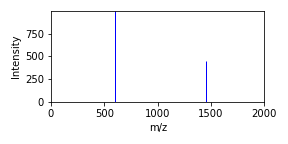

In [4]:
s

In [12]:
s.precursor.mz

1467.0061

In [5]:
dir(s)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_filtered',
 '_props',
 '_repr_png_',
 '_repr_svg_',
 'change_mass_info',
 'charge',
 'collision_energy',
 'collision_gas',
 'column',
 'composite_score',
 'copy',
 'cosine_score',
 'estimated_ri',
 'estimated_ri_error',
 'ev',
 'evenly_space',
 'exact_mass',
 'experimental_ri',
 'experimental_ri_data',
 'experimental_ri_error',
 'filter',
 'filtered',
 'formula',
 'from_arrays',
 'from_arrow',
 'from_mol',
 'get_float_prop',
 'get_int_prop',
 'get_prop',
 'get_string_prop',
 'id',
 'identity',
 'inchi_key',
 'insource_voltage',
 'instrument',
 'instrument_type',
 'intersect',
 'ion_mode',
 'ionization'

In [6]:
table.column_names

['id',
 'charge',
 'ev',
 'instrument',
 'instrument_type',
 'ion_mode',
 'ionization',
 'name',
 'nce',
 'intensity',
 'product_massinfo',
 'mz',
 'precursor_intensity',
 'precursor_massinfo',
 'precursor_mz',
 'spectrum_fp',
 'spectrum_fp_count',
 'spectrum_interval_fp',
 'spectrum_interval_fp_count',
 'aromatic_rings',
 'collision_energy',
 'collision_gas',
 'column',
 'ecfp4',
 'ecfp4_count',
 'estimated_ri',
 'estimated_ri_error',
 'exact_mass',
 'exact_mw',
 'experimental_ri',
 'experimental_ri_data',
 'experimental_ri_error',
 'formula',
 'has_2d',
 'has_conformer',
 'has_tms',
 'hba',
 'hbd',
 'inchi_key',
 'inchi_key_orig',
 'insource_voltage',
 'isomeric_smiles',
 'mol',
 'num_atoms',
 'num_undef_double',
 'num_undef_stereo',
 'rotatable_bonds',
 'sample_inlet',
 'set',
 'smiles',
 'stdnp',
 'stdnp_data',
 'stdnp_error',
 'stdpolar',
 'stdpolar_data',
 'stdpolar_error',
 'synonyms',
 'tpsa',
 'vial_id']

In [17]:
table.select(['id','name','precursor_mz']).to_pandas()

,id,name,precursor_mz
0,1035166,"1',3'-Bis[1,2-dilinoleoyl-sn-glycero-3-phospho...",1467.0061
1,1035167,"1',3'-Bis[1,2-dilinoleoyl-sn-glycero-3-phospho...",1467.0061
2,1035168,"1',3'-Bis[1,2-dilinoleoyl-sn-glycero-3-phospho...",1467.0061
3,1035169,"1',3'-Bis[1,2-dilinoleoyl-sn-glycero-3-phospho...",1467.0061
4,1035170,"1',3'-Bis[1,2-dilinoleoyl-sn-glycero-3-phospho...",1467.0061


In [8]:
from massspec.utils.tables import row_view
row = row_view(table, 3)

In [10]:
row.precursor_massinfo().tolerance()

10.0

In [32]:
dir(row.product_massinfo())

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'evenly_spaced',
 'get',
 'mass_type',
 'neutral_loss',
 'neutral_loss_charge',
 'struct',
 'tolerance',
 'tolerance_type']

In [34]:
row.product_massinfo().get('tolerance')

<bound method struct_view.<locals>.add_accessor_fn.<locals>.fn_scalar of <massspec.utils.tables.struct_view.<locals>.struct_accessor object at 0x7f0946820c40>>

In [11]:
table = create_dataset(cols=[int],rows=20)
table.nbytes

160

In [17]:
col = pa.array(["Why is my car still dirty?"] * table.num_rows)
#col = pa.array(["Why is my car still dirty?"] * table.num_rows).dictionary_encode()
col.nbytes

604

In [18]:
col.value_counts()

-- is_valid: all not null
-- child 0 type: string
  [
    "Why is my car still dirty?"
  ]
-- child 1 type: int64
  [
    20
  ]

In [19]:
col

[
  "Why is my car still dirty?",
  "Why is my car still dirty?",
  "Why is my car still dirty?",
  "Why is my car still dirty?",
  "Why is my car still dirty?",
  "Why is my car still dirty?",
  "Why is my car still dirty?",
  "Why is my car still dirty?",
  "Why is my car still dirty?",
  "Why is my car still dirty?",
  "Why is my car still dirty?",
  "Why is my car still dirty?",
  "Why is my car still dirty?",
  "Why is my car still dirty?",
  "Why is my car still dirty?",
  "Why is my car still dirty?",
  "Why is my car still dirty?",
  "Why is my car still dirty?",
  "Why is my car still dirty?",
  "Why is my car still dirty?"
]

In [20]:
col.get_total_buffer_size()

AttributeError: 'pyarrow.lib.StringArray' object has no attribute 'get_total_buffer_size'